In [1]:
%matplotlib inline


Section 2: Extracting signals from a brain parcellation
============================================

Here we show how to extract signals from a brain parcellation and compute
a correlation matrix.

We also show the importance of defining good confounds signals: the
first correlation matrix is computed after regressing out simple
confounds signals: movement regressors, white matter and CSF signals, ...
The second one is without any confounds: all regions are connected to
each other.


One reference that discusses the importance of confounds is `Varoquaux and
Craddock, Learning and comparing functional connectomes across subjects,
NeuroImage 2013
<http://www.sciencedirect.com/science/article/pii/S1053811913003340>`_.




#### Run the cell below in order to activate the tutorial download script (otherwise, ignore it!)

In [29]:
import warnings

import numpy as np
import os.path

from sklearn.datasets.base import Bunch
from nilearn.datasets.utils import _get_dataset_dir, _fetch_files


def fetch_data(n_subjects=30, data_dir=None, url=None, resume=True,
               verbose=1):
    """Download and load the dataset.

    Parameters
    ----------
    n_subjects: int, optional
        The number of subjects to load from maximum of 40 subjects.
        By default, 30 subjects will be loaded. If None is given,
        all 40 subjects will be loaded.

    data_dir: string, optional
        Path of the data directory. Used to force data storage in a specified
        location. Default: None

    url: string, optional
        Override download URL. Used for test only (or if you setup a mirror of
        the data). Default: None

    Returns
    -------
    data: sklearn.datasets.base.Bunch
        Dictionary-like object, the interest attributes are :
         - 'func': Paths to functional resting-state images
         - 'phenotypic': Explanations of preprocessing steps
         - 'confounds': CSV files containing the nuisance variables

    References
    ----------
    :Download:
        https://openneuro.org/datasets/ds000228/versions/00001

    """

    if url is None:
        url = 'https://openneuro.org/crn/datasets/ds000228/snapshots/00001/files/'

    # Preliminary checks and declarations
    dataset_name = 'ds000228'
    data_dir = _get_dataset_dir(dataset_name, data_dir=data_dir,
                                verbose=verbose)
    max_subjects = 155
    if n_subjects is None:
        n_subjects = max_subjects
    if n_subjects > max_subjects:
        warnings.warn('Warning: there are only %d subjects' % max_subjects)
        n_subjects = max_subjects
    ids = range(1, n_subjects + 1)

    # First, get the metadata
    phenotypic = (
            'participants.tsv',
            url + 'participants.tsv', dict())

    phenotypic_file = _fetch_files(data_dir, [phenotypic], resume=resume,
                              verbose=verbose)[0]

    # Load the csv file
    phenotypic = np.genfromtxt(phenotypic_file, names=True, delimiter='\t',
                               dtype=None)

    # Keep phenotypic information for selected subjects
    int_ids = np.asarray(ids, dtype=int)
    phenotypic = phenotypic[[i - 1 for i in int_ids]]

    # Download dataset files

    functionals = [
        'derivatives:fmriprep:sub-pixar%03i:sub-pixar%03i_task-pixar_run-001_swrf_bold.nii.gz' % (i, i)
        for i in ids]
    urls = [url + name for name in functionals]
    functionals = _fetch_files(
        data_dir, zip(functionals, urls, (dict(),) * n_subjects),
        resume=resume, verbose=verbose)

    confounds = [
        'derivatives:fmriprep:sub-pixar%03i:sub-pixar%03i_task-pixar_run-001_ART_and_CompCor_nuisance_regressors.mat'
        % (i, i)
        for i in ids]
    confound_urls = [url + name for name in confounds]

    confounds = _fetch_files(
        data_dir, zip(confounds, confound_urls, (dict(),) * n_subjects),
        resume=resume, verbose=verbose)

    return Bunch(func=functionals, confounds=confounds,
                 phenotypic=os.path.join(data_dir, phenotypic_file),
                 description='ds000228')

Retrieve the atlas and the data
--------------------------------



Since we're using rs-fmri data, it makes sense to use an atlas defined using rs-fmri data

Let's use the MIST atlas, created here in Montreal using the BASC method. This atlas has multiple resolutions, for larger networks or finer-grained ROIs. Let's use a 64-ROI atlas to allow some detail, but to ultimately keep our connectivity matrices manageable

In [2]:
from nilearn import datasets

parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064


print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Atlas ROIs are located in nifti image (4D) at: /Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


Let's have a look at that atlas

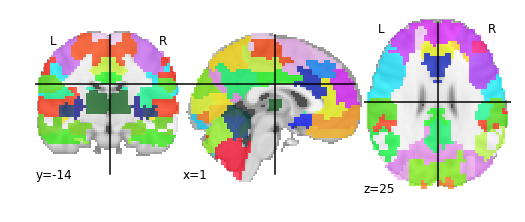

In [4]:
from nilearn import plotting

plotting.plot_roi(atlas_filename)

Great, let's load an example 4D fmri time-series for one subject

We have prepared some data especially for this tutorial. It is based on an open dataset of children and young adults. More details can be found here:

https://openneuro.org/datasets/ds000228/versions/00001

If you have already downloaded the data, this next line should happen instantly. Otherwise, the data download will begin.

In [7]:
# One subject of resting-state data
data = fetch_data(n_subjects=1)


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:68: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [8]:
fmri_filenames = data.func[0]
print('fmri timeseries are located in nifti image (4D) at: %s' %
       fmri_filenames)  # 4D data

fmri timeseries are located in nifti image (4D) at: /Users/jakevogel/nilearn_data/ds000228/derivatives:fmriprep:sub-pixar001:sub-pixar001_task-pixar_run-001_swrf_bold.nii.gz


And let's have a look at that 4D resting-state image

In [9]:
plotting.plot_stat_map(fmri_filenames)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See http://nilearn.github.io/manipulating_images/input_output.html.

Uh oh! An error! What's the problem here?

In [11]:
# Let's just a look at a single frame
# First we load the image into memory
from nilearn import image

myImg = image.load_img(fmri_filenames)
print(myImg.shape)

(79, 95, 68, 168)


In [12]:
# Now, let's isolate the first frame
first_frame = image.index_img(myImg, 0)
print(first_frame.shape)

(79, 95, 68)


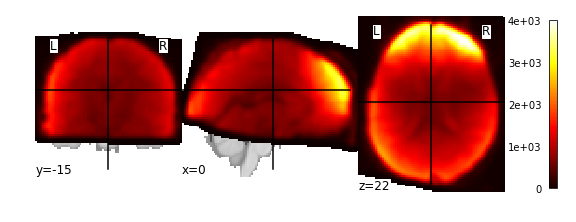

In [13]:
# Now let's try to plot it
plotting.plot_stat_map(first_frame)

The first frame can be a bit wonky. What about an average image?

In [14]:
averaged_Img = image.mean_img(image.mean_img(myImg))
averaged_Img.shape

(79, 95, 68)

And plot!

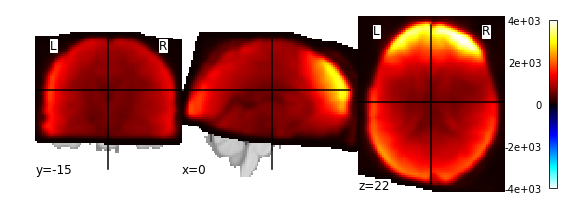

In [15]:
plotting.plot_stat_map(averaged_Img)

### Extract signals on a parcellation defined by labels
Using the NiftiLabelsMasker

So we've loaded our atlas and 4D data for a single subject. Let's practice extracting features!

In [16]:
# here is a short script to deal with the confounds in this particular dataset
# don't worry about the details
# but here is an example of how you can create your own function!

import h5py
import numpy as np

def prepare_confounds(conf, key = 'R', transpose=True):
    arrays = {}
    f = h5py.File(conf)
    for k, v in f.items():
        arrays[k] = np.array(v)
    
    if transpose:
        output = arrays[key].T
    else:
        output = arrays[key]
    
    return output

In [17]:
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
conf = prepare_confounds(data.confounds[0])
time_series = masker.fit_transform(myImg, confounds=conf)

[NiftiLabelsMasker.fit_transform] loading data from /Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels
[Memory]    0.7s, 0.0min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min


So what did we just create here?

In [18]:
type(time_series)

numpy.ndarray

In [19]:
time_series.shape

(168, 64)

Its a 168 (timeframes) x 64 (region) array!

What are these "confounds" and how are they used?

In [20]:
data.confounds

['/Users/jakevogel/nilearn_data/ds000228/derivatives:fmriprep:sub-pixar001:sub-pixar001_task-pixar_run-001_ART_and_CompCor_nuisance_regressors.mat']

In [21]:
conf.shape

(168, 29)

In [22]:
from pandas import DataFrame
DataFrame(conf).head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.270012,2.294844,-0.389217,0.410281,-0.170325
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.540024,4.589688,-0.778435,0.820561,-0.340651
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.810036,6.884532,-1.167652,1.230842,-0.510976
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.080048,9.179377,-1.556870,1.641123,-0.681301


### Compute and display a correlation matrix



In [23]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
correlation_matrix.shape

(64, 64)

Plot the correlation matrix

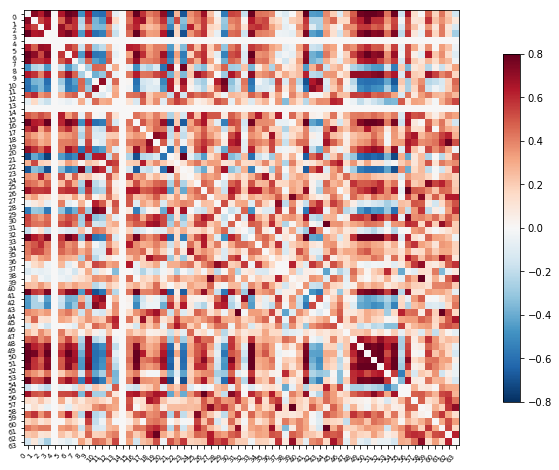

In [27]:
import numpy as np
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

# The labels we have start with the background (0), hence we skip the
# first label
plotting.plot_matrix(correlation_matrix, figure=(10, 8), 
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

# matrices are ordered for block-like representation

### Same thing without confounds, to stress the importance of confounds



[NiftiLabelsMasker.fit_transform] loading data from /Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[Memory]  332.2s, 5.5min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


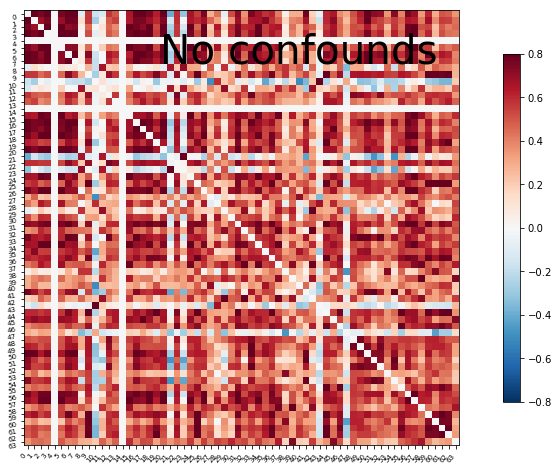

In [28]:
time_series = masker.fit_transform(myImg)
# Note how we did not specify confounds above. This is bad!

correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), 
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8,
                    title='No confounds', reorder=False)

plotting.show()

**Exercise** We generated a connectivity matrix with one subject. Try doing the same thing with a second subject. Are the connectomes similar? What about the influence of confounds?

Hint, to get a second subject, change to n=2 on the download function

In [ ]:
## WORKSPACE


